# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

9812


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc
import numpy as np

## 1.1 Define output folder

In [4]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')

Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2\figures.


## 1.2 setting up plotting parameters

In [5]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rc('font', family='serif')
plt.rc('font', serif='Arial')


# Other required plotting parameters
_dpi = 300
_font_size = 7.5
_page_width = 5.5

from ImageAnalysis3.figure_tools import _double_col_width, _single_col_width, _ticklabel_size,_ticklabel_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})   

In [6]:
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]

celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}



# 2. Load gProfiler results

## long genes used for analysis

## load gProfier results

Data can be found in the repository as [gProfiler_mmusculus_data](../5_radial_position/resources/gProfiler_mmusculus_9-8-2023_12-07-00%20PM__intersections.csv)

Data is downloaded from online gProfiler tool at <https://biit.cs.ut.ee/gprofiler/gost>

In [17]:
gPro_fname = os.path.join(output_analysis_folder, r'gProfiler_mmusculus_9-8-2023_12-07-00 PM__intersections.csv')

gPro_df = pd.read_csv(gPro_fname, skiprows=17)
gPro_df 

,source,term_name,term_id,highlighted,adjusted_p_value,negative_log10_of_adjusted_p_value,term_size,query_size,intersection_size,effective_domain_size,intersections
0,GO:MF,protein binding,GO:0005515,True,1.393195e-08,7.855988,10491,74,59,25177,"ANK2,ANK3,ATXN1,CADM2,CADPS,CDH12,CDH18,CHRM3,..."
1,GO:MF,cell adhesion molecule binding,GO:0050839,False,8.292908e-06,5.081293,292,74,10,25177,"ANK3,CDH12,CDH18,CTNNA2,CTNNA3,DMD,LRRC4C,NLGN..."
2,GO:MF,potassium channel activity,GO:0005267,True,3.592536e-05,4.444599,119,74,7,25177,"GRIK2,HCN1,KCNB2,KCND2,KCNH7,KCNIP4,KCNQ5"
3,GO:MF,monoatomic ion gated channel activity,GO:0022839,False,1.768536e-04,3.752386,308,74,9,25177,"GABRB1,GRID2,GRIK2,HCN1,KCNB2,KCND2,KCNH7,KCNI..."
4,GO:MF,gated channel activity,GO:0022836,False,1.970861e-04,3.705344,312,74,9,25177,"GABRB1,GRID2,GRIK2,HCN1,KCNB2,KCND2,KCNH7,KCNI..."
...,...,...,...,...,...,...,...,...,...,...,...
228,GO:CC,receptor complex,GO:0043235,True,3.232907e-02,1.490407,403,76,7,27262,"ERBB4,GABRB1,GRID2,GRIK2,LRP1B,LRRTM4,NLGN1"
229,GO:CC,cellular anatomical entity,GO:0110165,False,3.728185e-02,1.428503,22796,76,74,27262,"ANK2,ANK3,ATXN1,BRINP3,CADM2,CADPS,CDH12,CDH18..."
230,GO:CC,cell body membrane,GO:0044298,False,3.973881e-02,1.400785,38,76,3,27262,"CADM2,KCNB2,KCND2"
231,GO:CC,neuromuscular junction,GO:0031594,False,4.503072e-02,1.346491,101,76,4,27262,"ANK3,ERBB4,NLGN1,NRG1"


# 3. Plot

## plot driver terms as table

In [86]:
driver_gPro_df = gPro_df[gPro_df['highlighted']==True]
driver_gPro_df['fold_enrichment'] = ((driver_gPro_df['intersection_size']/driver_gPro_df['query_size'])/
                                     (driver_gPro_df['term_size']/driver_gPro_df['effective_domain_size']))

driver_gPro_df['ID'] = driver_gPro_df.index
plot_df = driver_gPro_df[['ID','source','term_name','term_id','adjusted_p_value','fold_enrichment']]
plot_df['fold_enrichment'] = round(plot_df['fold_enrichment'],2)
plot_df = plot_df.rename(columns={"source": "Source",
                        "term_name": "Term name",
                        "term_id": "Term ID",
                        "adjusted_p_value": "Adj. p-value",
                        "fold_enrichment": "Fold enrichment",
                       })

plot_df["Adj. p-value"] = plot_df["Adj. p-value"].apply(lambda x: str("{:e}".format(x)))
plot_df["Adj. p-value"] = plot_df["Adj. p-value"].apply(lambda x: 
                                                            (x.split('e-')[0][:4]+ 'e-' + x.split('e-')[-1])
                                                           )
plot_df 

C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_9812\1978925821.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_gPro_df['fold_enrichment'] = ((driver_gPro_df['intersection_size']/driver_gPro_df['query_size'])/
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_9812\1978925821.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_gPro_df['ID'] = driver_gPro_df.index
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_9812\1978925821.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy o

,ID,Source,Term name,Term ID,Adj. p-value,Fold enrichment
0,0,GO:MF,protein binding,GO:0005515,1.39e-08,1.91
2,2,GO:MF,potassium channel activity,GO:0005267,3.59e-05,20.01
9,9,GO:MF,"phosphatidylinositol-4,5-bisphosphate binding",GO:0005546,3.85e-03,19.11
16,16,GO:MF,PDZ domain binding,GO:0030165,1.52e-02,14.42
18,18,GO:MF,calcium ion binding,GO:0005509,2.78e-02,4.73
22,22,GO:MF,postsynaptic neurotransmitter receptor activity,GO:0098960,3.57e-02,18.90
24,24,GO:BP,nervous system development,GO:0007399,6.48e-20,5.90
35,35,GO:BP,cell-cell adhesion,GO:0098609,5.72e-12,8.76
43,43,GO:BP,regulation of membrane potential,GO:0042391,3.98e-10,12.28
126,126,GO:BP,regulation of system process,GO:0044057,3.18e-03,6.23


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


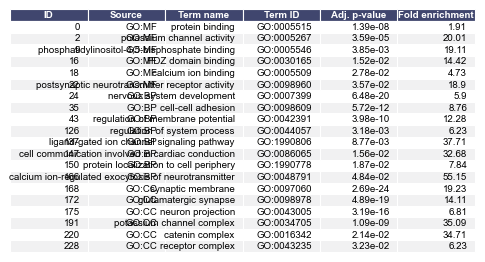

In [89]:
def render_mpl_table(data, col_width=1, row_height=0.2, font_size=7.,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax


fig,ax = render_mpl_table(plot_df, header_columns=0, col_width=1, row_height=0.15, font_size=7.,)
fig.savefig(os.path.join(output_figure_folder, f"gProfiler_table.pdf"),transparent=True,
            bbox_inches='tight', dpi=300)

## plot dots with signifiance

In [93]:
gPro_df

,source,term_name,term_id,highlighted,adjusted_p_value,negative_log10_of_adjusted_p_value,term_size,query_size,intersection_size,effective_domain_size,intersections,fold_enrichment
0,GO:MF,protein binding,GO:0005515,True,1.393195e-08,7.855988,10491,74,59,25177,"ANK2,ANK3,ATXN1,CADM2,CADPS,CDH12,CDH18,CHRM3,...",1.913407
1,GO:MF,cell adhesion molecule binding,GO:0050839,False,8.292908e-06,5.081293,292,74,10,25177,"ANK3,CDH12,CDH18,CTNNA2,CTNNA3,DMD,LRRC4C,NLGN...",11.651703
2,GO:MF,potassium channel activity,GO:0005267,True,3.592536e-05,4.444599,119,74,7,25177,"GRIK2,HCN1,KCNB2,KCND2,KCNH7,KCNIP4,KCNQ5",20.013514
3,GO:MF,monoatomic ion gated channel activity,GO:0022839,False,1.768536e-04,3.752386,308,74,9,25177,"GABRB1,GRID2,GRIK2,HCN1,KCNB2,KCND2,KCNH7,KCNI...",9.941778
4,GO:MF,gated channel activity,GO:0022836,False,1.970861e-04,3.705344,312,74,9,25177,"GABRB1,GRID2,GRIK2,HCN1,KCNB2,KCND2,KCNH7,KCNI...",9.814319
...,...,...,...,...,...,...,...,...,...,...,...,...
228,GO:CC,receptor complex,GO:0043235,True,3.232907e-02,1.490407,403,76,7,27262,"ERBB4,GABRB1,GRID2,GRIK2,LRP1B,LRRTM4,NLGN1",6.230704
229,GO:CC,cellular anatomical entity,GO:0110165,False,3.728185e-02,1.428503,22796,76,74,27262,"ANK2,ANK3,ATXN1,BRINP3,CADM2,CADPS,CDH12,CDH18...",1.164440
230,GO:CC,cell body membrane,GO:0044298,False,3.973881e-02,1.400785,38,76,3,27262,"CADM2,KCNB2,KCND2",28.319252
231,GO:CC,neuromuscular junction,GO:0031594,False,4.503072e-02,1.346491,101,76,4,27262,"ANK3,ERBB4,NLGN1,NRG1",14.206357


In [219]:
sel_gPro_df[:4]

,source,term_name,term_id,highlighted,adjusted_p_value,negative_log10_of_adjusted_p_value,term_size,query_size,intersection_size,effective_domain_size,intersections,fold_enrichment,plot_y_pos
168,GO:CC,synaptic membrane,GO:0097060,True,2.692406e-24,23.569859,485,76,26,27262,"ANK2,ANK3,CHRM3,CNTNAP2,CTNNA2,DCC,DGKB,DMD,ER...",19.229843,265
169,GO:CC,cell junction,GO:0030054,False,4.217166e-22,21.374979,2294,76,41,27262,"ANK2,ANK3,ATXN1,CADM2,CADPS,CDH12,CDH18,CHRM3,...",6.411130,246
170,GO:CC,synapse,GO:0045202,False,2.385534e-21,20.622414,1677,76,36,27262,"ANK2,ANK3,ATXN1,CADM2,CADPS,CHRM3,CNTNAP2,CTNN...",7.700405,209
171,GO:CC,postsynaptic membrane,GO:0045211,False,1.278441e-20,19.893319,332,76,21,27262,"ANK2,ANK3,CHRM3,CTNNA2,DCC,DGKB,DMD,ERBB4,GABR...",22.689521,244


GO:MF 24
GO:BP 144
GO:CC 65


meta NOT subset; don't know how to subset; dropped


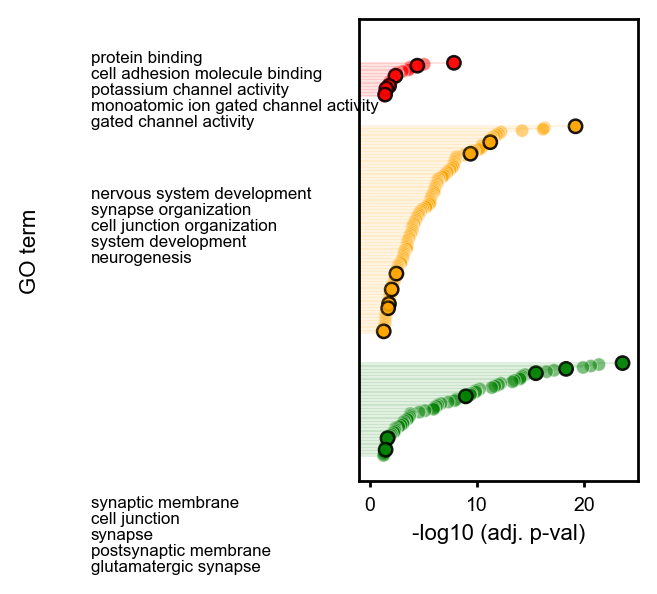

In [294]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(1.8,3),dpi=200)

gPro_df['fold_enrichment'] = ((gPro_df['intersection_size']/gPro_df['query_size'])/
                                     (gPro_df['term_size']/gPro_df['effective_domain_size']))

new_top_tick = []
new_top_term = []
top_num = 5
new_term_order = []
term_order = gPro_df.index
for _i, _source in enumerate(['GO:MF','GO:BP','GO:CC']):
    sel_gPro_df = gPro_df[gPro_df['source']==_source]
    sel_gPro_df_top = sel_gPro_df[:top_num]
    print(_source, len(sel_gPro_df))
    
    sel_term_order = list(sel_gPro_df.index)
    #sel_term_order = [o+i*1 for i,o in enumerate(sel_term_order)] # space btw dots
    sel_term_order = [o+20*_i for o in sel_term_order] # space btw source

    #for i in range(0,100):
        #random.shuffle(sel_term_order)
    new_term_order.extend(sel_term_order)
    new_top_term.extend(sel_gPro_df_top['term_name'])
    new_top_tick.extend(sel_term_order[:top_num])
    

color_dict = {'GO:MF':'red','GO:BP':'orange','GO:CC':'green'}
gPro_df['plot_y_pos']=new_term_order
sns.scatterplot(data=gPro_df, y=new_term_order, x="negative_log10_of_adjusted_p_value", 
                hue="source", sizes=0.1, alpha = 0.5, palette=color_dict,
                #size="fold_enrichment", size_norm=(1, 100),
                ax=ax,legend=False, 
               )

color_list = [color_dict[i] for i in gPro_df['source']]
plt.hlines(y=gPro_df['plot_y_pos'], xmin=-1, 
           xmax=gPro_df['negative_log10_of_adjusted_p_value'], 
           linewidth=0.1, alpha =0.8,
           color=color_list,
          )

for _i, (_term,_tick) in enumerate(zip(new_top_term, new_top_tick)):
    ax.text(-26,
            _tick+10*_i,
            _term, fontsize=6.1)

    

# highlight driver
driver_gPro_df = gPro_df[gPro_df['highlighted']==True]
sns.scatterplot(data=driver_gPro_df, y='plot_y_pos', x="negative_log10_of_adjusted_p_value", 
                hue="source", sizes=0.6, alpha = 0.9, palette=color_dict,
                #size="fold_enrichment", size_norm=(1, 100),
                ax=ax,legend=False, edgecolor='black',linewidth=0.9
               )


#for _term in driver_gPro_df.index:
    #ax.text(driver_gPro_df.loc[_term]["negative_log10_of_adjusted_p_value"]+1,
            #driver_gPro_df.loc[_term]["plot_y_pos"]-2,
            #_term,)

plt.ylim([290,-30])
plt.xlim([-1,25])
ax.set_xlabel(f"-log10 (adj. p-val)", fontsize=8, rotation=0,labelpad=3,)
ax.set_ylabel(f"GO term", fontsize=8, rotation=90,labelpad=110,)
ax.tick_params('x',labelsize=7, length=2,rotation=0)
plt.yticks([])

fig.savefig(os.path.join(output_figure_folder, f"gProfiler_scatter.pdf"),transparent=True,
            bbox_inches='tight', dpi=300)